In [2]:
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import numpy as np
from datetime import datetime

## Rebalancing strategy on value stocks
We pick several values stocks, and develop a swing strategy, and compare the results with buy and hold strategy.

In [40]:
tickers = ['BMY', 'WMT', 'KO','VZ','IBM','T']

In [41]:
stocks = yf.download(tickers, start = "2005-01-01", end = "2015-01-01")

[*********************100%***********************]  6 of 6 completed


In [42]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2005-01-03 to 2014-12-31
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, BMY)  2517 non-null   float64
 1   (Adj Close, IBM)  2517 non-null   float64
 2   (Adj Close, KO)   2517 non-null   float64
 3   (Adj Close, T)    2517 non-null   float64
 4   (Adj Close, VZ)   2517 non-null   float64
 5   (Adj Close, WMT)  2517 non-null   float64
 6   (Close, BMY)      2517 non-null   float64
 7   (Close, IBM)      2517 non-null   float64
 8   (Close, KO)       2517 non-null   float64
 9   (Close, T)        2517 non-null   float64
 10  (Close, VZ)       2517 non-null   float64
 11  (Close, WMT)      2517 non-null   float64
 12  (High, BMY)       2517 non-null   float64
 13  (High, IBM)       2517 non-null   float64
 14  (High, KO)        2517 non-null   float64
 15  (High, T)         2517 non-null   float64
 16  (High, VZ)        2517 n

In [43]:
stocks.drop(columns=[column for column in stocks.columns if column[0] == 'Adj Close'], inplace=True)
stocks.head(3)

Close                                                      \
                  BMY        IBM      KO          T         VZ        WMT   
Date                                                                        
2005-01-03  25.430000  97.750000  20.770  25.590000  36.413578  53.349998   
2005-01-04  25.150000  96.699997  20.480  25.320000  36.044857  53.220001   
2005-01-05  24.790001  96.500000  20.385  25.440001  35.990898  53.290001   

                 High                                   ...       Open         \
                  BMY        IBM         KO          T  ...         KO      T   
Date                                                    ...                     
2005-01-03  25.670000  99.099998  20.985001  25.980000  ...  20.950001  25.98   
2005-01-04  25.610001  98.419998  20.825001  25.780001  ...  20.770000  25.76   
2005-01-05  25.020000  97.830002  20.600000  25.790001  ...  20.500000  25.43   

                               Volume                                         \
                   VZ    WMT      BMY      IBM        KO         T        VZ   
Date                                                                           
2005-01-03  36.692368  53.75  4997300  5295200  14072000   9900500   9236061   
2005-01-04  36.584450  53.77  5681300  5711000  16860200  11879200  11680234   
2005-01-05  36.080830  53.50  5606300  5646700  13271000  11064500   8201616   

                      
                 WMT  
Date                  
2005-01-03  16078400  
2005-01-04  10596700  
2005-01-05   8241500  

[3 rows x 30 columns]

In [44]:
class proportional_balance(bt.Strategy):
    def __init__(self):
        pass
    
    def next(self):      
        today = self.data.datetime.date
        pct = 0.95/len(tickers)
        for stock in tickers:
            self.order_target_percent(target=pct, data=stock)
            
#     def stop(self):
#         print('The final porfolio value is {}'.format(self.broker.getvalue()))


In [45]:
cerebro = bt.Cerebro()
buy_and_hold=0
for stock in tickers:
    df = stocks[[column for column in stocks.columns if (column[1] == stock)]]
    df.columns = df.columns.get_level_values(0)
    df = df.div(df['Open'][0])
    buy_and_hold += df['Open'][-1]
#     print(df)
    datafeed = bt.feeds.PandasData(dataname=df)
    cerebro.adddata(datafeed, name=stock)
buy_and_hold /= len(tickers)

In [46]:
cerebro.addstrategy(proportional_balance)

0

In [47]:
cerebro.broker.setcash(100000)

In [48]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)

<IPython.core.display.Javascript object>


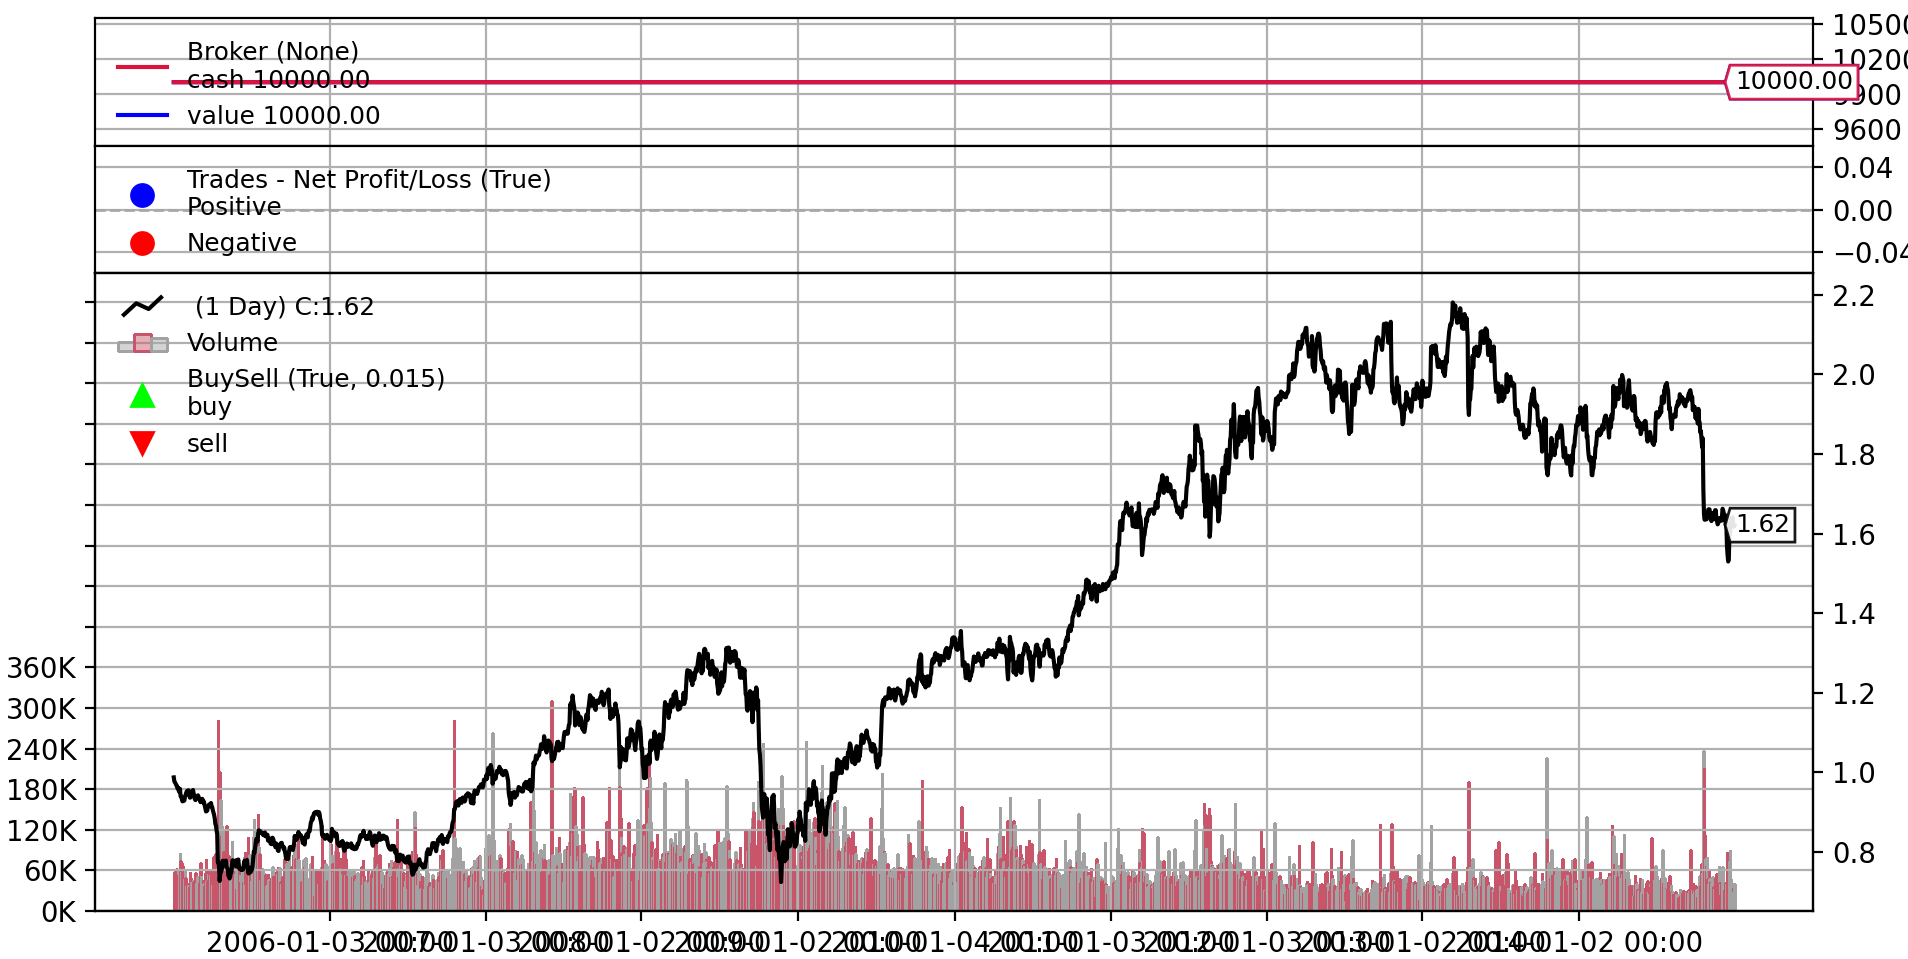

[[<Figure size 432x288 with 14 Axes>]]

In [49]:
res = cerebro.run()[0]
cerebro.plot(width=200, height=200)

##### We compute some metrics, including Sharpe ratio and our final porfolio value (with initial cash = 10^5)

In [50]:
print('the Sharpe ratio of this strategy is {}, and our final porfolio value is {}'.format(res.analyzers.sharperatio.get_analysis()['sharperatio'], res.broker.getvalue()))

the Sharpe ratio of this strategy is 0.4998193661918482, and our final porfolio value is 177999.00498102908


In [51]:
print("If instead we use buy and hold, the resulting value is {}".format(buy_and_hold*10**5))

If instead we use buy and hold, the resulting value is 169995.47130236035


#### Here we have some other metrics.

In [14]:
res.analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 22),
                 ('drawdown', 1.9099711164267514),
                 ('moneydown', 4413.439419013652),
                 ('max',
                  AutoOrderedDict([('len', 760),
                                   ('drawdown', 29.683296679435724),
                                   ('moneydown', 38246.49241122416)]))])

##### Summary of Rebalancing strategy
We see that in this situation, our strategy actually ourperform the buy and hold strategy, with roughly 8% more profits across this peroid.

## Dual Thrust Strategy on Nasdaq index

##### Data preprocess

In [6]:
nasdaq_1m=pd.read_csv('nasdaq_1m.csv')

In [7]:
nasdaq_1m.head(3)

,01/04/2007;17:00:00;1791.75;1791.75;1790.75;1790.75;56
0,01/04/2007;17:01:00;1791;1791;1790.75;1790.75;11
1,01/04/2007;17:03:00;1790.5;1790.5;1789.75;1789...
2,01/04/2007;17:04:00;1790.25;1790.25;1790.25;17...


In [8]:
from datetime import datetime

In [9]:
nasdaq_1m.rename(columns={'01/04/2007;17:00:00;1791.75;1791.75;1790.75;1790.75;56':'column'}, inplace=True)

In [10]:
nasdaq_1m['time']=nasdaq_1m['column'].apply(lambda x: x.split(';')[0]+" "+x.split(';')[1]).apply(lambda x: datetime.strptime(x, '%d/%m/20%y %H:%M:%S'))

In [11]:
nasdaq_1m['open']=nasdaq_1m['column'].apply(lambda x: x.split(';')[2]).astype('float')
nasdaq_1m['high']=nasdaq_1m['column'].apply(lambda x: x.split(';')[3]).astype('float')
nasdaq_1m['low']=nasdaq_1m['column'].apply(lambda x: x.split(';')[4]).astype('float')
nasdaq_1m['close']=nasdaq_1m['column'].apply(lambda x: x.split(';')[5]).astype('float')
nasdaq_1m['volume']=nasdaq_1m['column'].apply(lambda x: x.split(';')[6]).astype('int32')

In [12]:
nasdaq_1m.set_index('time', inplace=True)

In [13]:
nasdaq_1m.drop(columns='column', inplace=True)

In [14]:
nasdaq_1m['open'].head(3)

time
2007-04-01 17:01:00    1791.00
2007-04-01 17:03:00    1790.50
2007-04-01 17:04:00    1790.25
Name: open, dtype: float64

In [15]:
nasdaq_1m_used=nasdaq_1m.loc['2020-01-01':'2020-06-30']
nasdaq_1m_used.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172493 entries, 2020-01-01 17:00:00 to 2020-06-30 23:59:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    172493 non-null  float64
 1   high    172493 non-null  float64
 2   low     172493 non-null  float64
 3   close   172493 non-null  float64
 4   volume  172493 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 7.2 MB


In [16]:
nasdaq_1m.fillna('ffill', inplace=True)

In [17]:
nq_minute_bar=bt.feeds.PandasData(dataname=nasdaq_1m_used,
                            fromdate=datetime(2020,1,1),
                            todate=datetime(2020,5,30),
                            timeframe=bt.TimeFrame.Minutes)

In [23]:
cerebro2=bt.Cerebro()
cerebro2.adddata(nq_minute_bar)
cerebro2.resampledata(nq_minute_bar, timeframe=bt.TimeFrame.Days)
cerebro2.broker.set_cash(100000)

In [24]:
class DT_Line(bt.Indicator):
    lines=('U','D')
    params=(('period',5), ('k_u',0.8), ('k_d',0.5))
    
    def __init__(self):        
        self.addminperiod(self.p.period+1)
        
    def next(self):
        HH=max(self.data.high.get(-1, size=self.p.period))
        LC=min(self.data.close.get(-1, size=self.p.period))
        HC=max(self.data.close.get(-1,size=self.p.period))
        LL=min(self.data.low.get(-1,size=self.p.period))
        R=max(HH-LC,HC-LL)
        
        self.lines.U[0]=self.data.open[0]+self.p.k_u*R
        self.lines.D[0]=self.data.open[0]-self.p.k_d*R

In [25]:
from datetime import time
class dualTrust(bt.Strategy):
    params=(('period',2),('k_u',0.7),('k_d', 0.7))
    
    def __init__(self):
#         self.data1.plotinfo.plot=False
        self.dataclose=self.data0.close
        self.D_Line =DT_Line(self.data1, period=self.p.period, k_u=self.p.k_u, k_d=self.p.k_d)
        self.D_Line=self.D_Line()
        self.D_Line.plotinfo.plotmaster=self.data0
        
        self.buy_signal=bt.indicators.CrossOver(self.dataclose, self.D_Line.U)
        self.sell_signal=bt.indicators.CrossDown(self.dataclose, self.D_Line.D)
        
    def next(self):
        
        if self.data.datetime.time() > time(9,10,0) and self.data.datetime.time() < time(15,30,0):
            if not self.position and self.buy_signal[0]==1:
                self.order=self.buy()
            if not self.position and self.sell_signal[0]==1:
                self.order=self.sell()

            if self.getposition().size<0 and self.buy_signal[0]==1:
                self.order=self.close()
                self.order=self.buy()
            if self.getposition().size>0 and self.sell_signal[0]==1:
                self.order=self.close()
                self.order=self.sell()
        if  self.data.datetime.time() >= time(15, 56, 0) and self.position:
            self.order=self.close()
            
            
    def stop(self):
        print('period: {}, k_u: {}, k_d: {}, final_value: {}'.format(self.p.period, 
                                                                     self.p.k_u, self.p.k_d, self.broker.getvalue()))
            
        

In [26]:
cerebro2.addstrategy(dualTrust)
# cerebro2.optstrategy(dualTrust, period=range(1,5), k_u=[n/10.0 for n in range(2,10)], k_d=[n/10.0 for n in range(2,10)])
cerebro2.run()
# cerebro2.plot(width=200, height=200)

period: 2, k_u: 0.7, k_d: 0.7, final_value: 99224.5


<IPython.core.display.Javascript object>


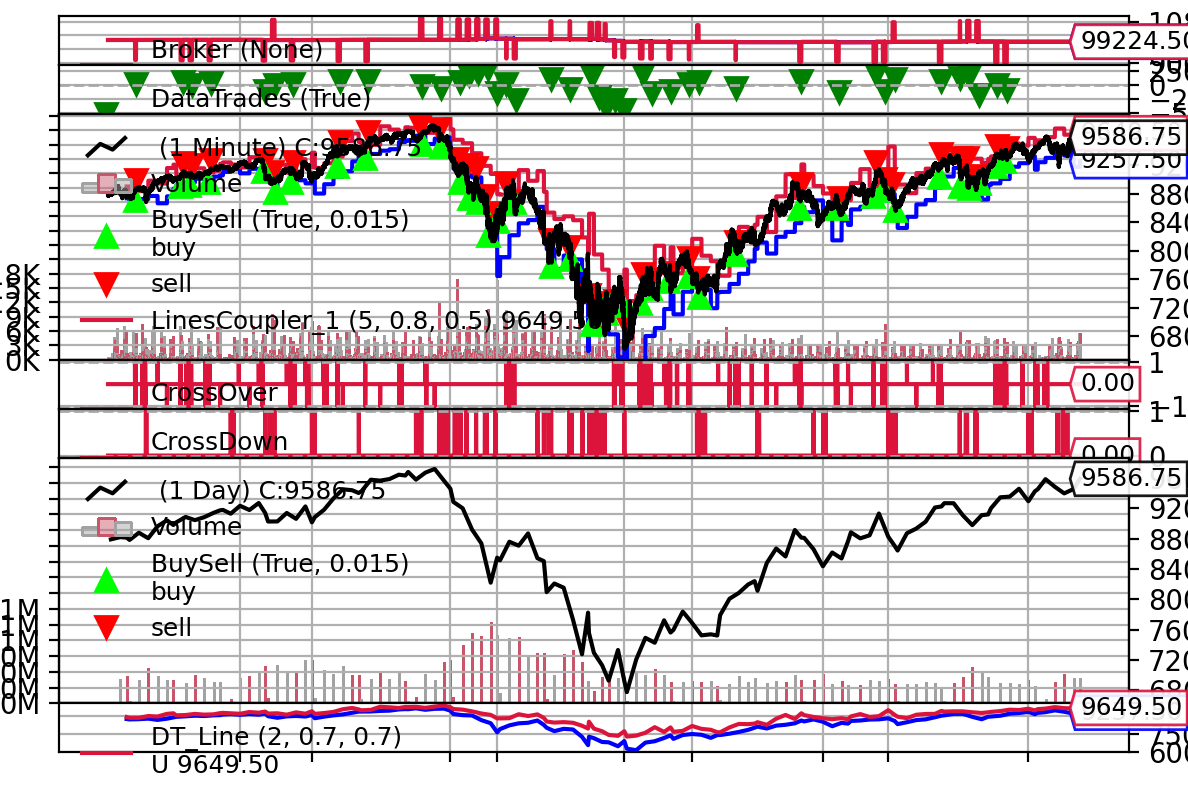

[[<Figure size 432x288 with 9 Axes>]]

In [27]:
cerebro2.plot()

## Momentum With Simple moving Average

In [3]:
class SMA(bt.Strategy):
    
    params=(('period',24),
           )
      
    def __init__(self):

        self.sma=bt.indicators.MovingAverageSimple(self.data, period=self.params.period) 
        self.sma_signals=bt.indicators.CrossOver(self.data.close, self.sma)    
        
    def next(self):
        buy_vol=3000
        ma=self.sma[0]
        pre_ma=self.sma[-1]
        
        if self.sma_signals[0]==1 and not self.position:           
            self.order=self.buy(size=buy_vol)
            
        if self.sma_signals[0]==1 and self.position:
            self.order=self.close()
            self.order=self.buy(size=buy_vol)
            
        if self.sma_signals[0]==-1 and not self.position:
            self.order=self.sell(size=buy_vol)
            
        if self.sma_signals[0]==-1 and self.position:
            self.order=self.close()
            self.order=self.sell(size=buy_vol)
    def stop(self):
        print("when period={}, the final porfolio value of this strategy is {}".format(self.p.period, self.broker.getvalue()))


In [12]:
df3 = yf.download(['IBM'], start = "2005-01-01", end = "2010-01-01")
df3 = df3.div(df3['Open'][0])
df3.head(3)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.000000,1.001314,0.982621,0.987673,0.626611,53503.081082
2005-01-04,0.987572,0.994443,0.975245,0.977064,0.619880,57704.354143
2005-01-05,0.976053,0.988481,0.974033,0.975043,0.618598,57054.662325


In [13]:
print("If we simply buy and hold, then the total return would be {}%".format(100*(df3['Open'][-1]-1)/1))

If we simply buy and hold, then the total return would be 33.78801862074856%


##### We test this strategy with various period

In [14]:
for period in range(3,15):
    cerebro3=bt.Cerebro()
    cerebro3.addstrategy(SMA, period=period)
    IBM_day=bt.feeds.PandasData(dataname=df3,
                                fromdate=datetime(2005,1,1),
                                todate=datetime(2015,1,1),
                                timeframe=bt.TimeFrame.Days)
    cerebro3.adddata(IBM_day)
    cerebro3.run()



when period=3, the final porfolio value of this strategy is 10264.629211584552
when period=4, the final porfolio value of this strategy is 9460.138591800513
when period=5, the final porfolio value of this strategy is 9212.185816495536
when period=6, the final porfolio value of this strategy is 9215.217223051559
when period=7, the final porfolio value of this strategy is 9061.230881802921
when period=8, the final porfolio value of this strategy is 9668.082027129427
when period=9, the final porfolio value of this strategy is 9467.413921282116
when period=10, the final porfolio value of this strategy is 9246.741029814852
when period=11, the final porfolio value of this strategy is 8753.259355624907
when period=12, the final porfolio value of this strategy is 8814.490622867555
when period=13, the final porfolio value of this strategy is 9957.867426609957
when period=14, the final porfolio value of this strategy is 10588.9670492182


In [10]:
# cerebro3.run()
# cerebro3.plot()

#### Next we will try to optimize it's parameter using a built in function
Note that the following code can not be run on jupyter notebook when used on Windows, perhaps because backtrader execute optimization parallelly. 

In [ ]:
cerebro4=bt.Cerebro()
IBM_day=bt.feeds.PandasData(dataname=df3,
                            fromdate=datetime(2005,1,1),
                            todate=datetime(2015,1,1),
                            timeframe=bt.TimeFrame.Days)
cerebro4.adddata(IBM_day)
# cerebro4.addstrategy(SMA)
cerebro4.optstrategy(SMA,period=range(5,25) )
cerebro4.run()
